## Python Peephole Optimizations

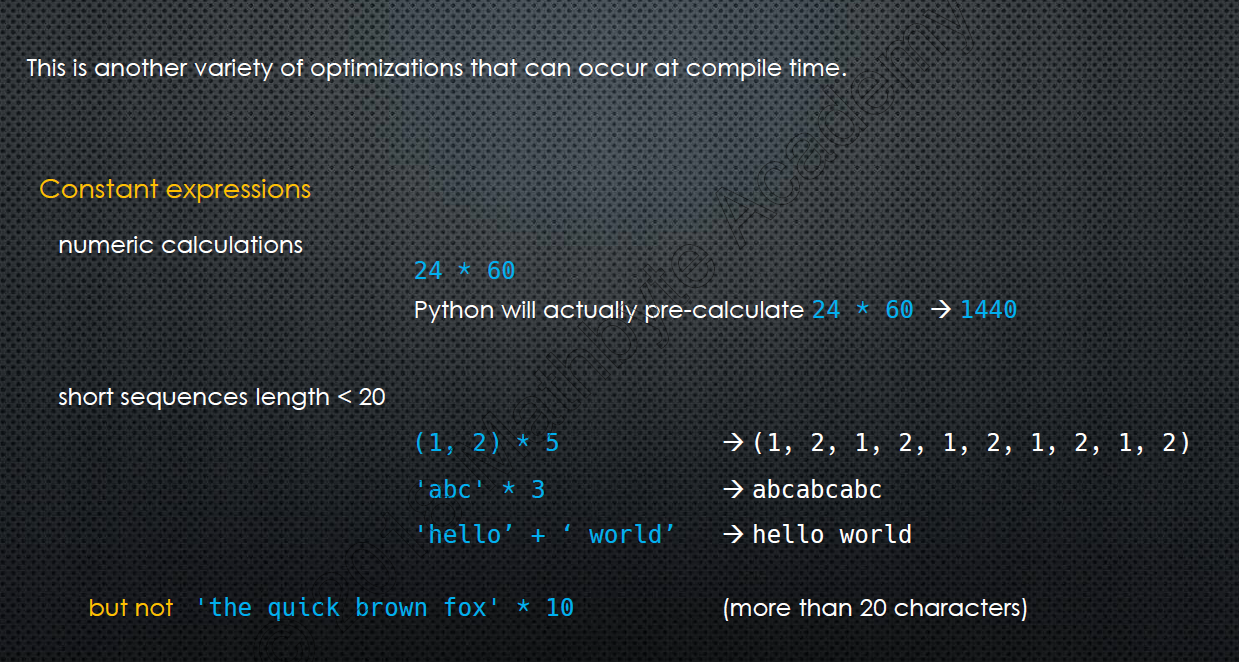

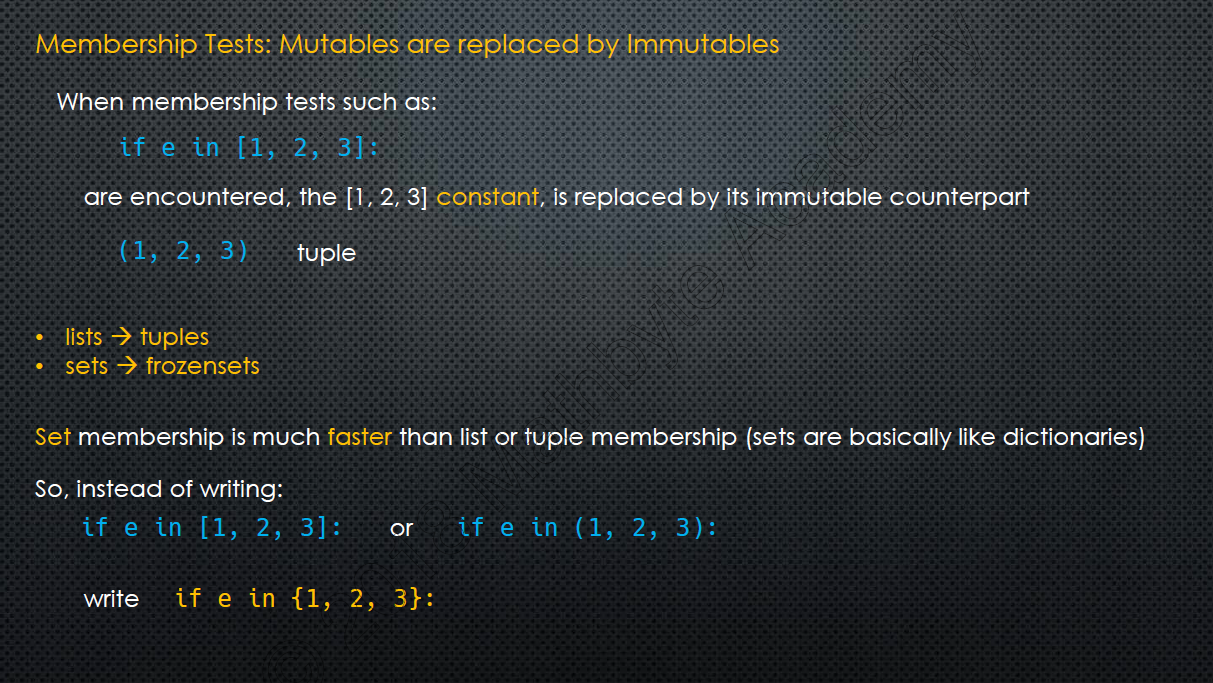

Peephole optimizations refer to a certain class of optimization strategies Python employs during any compilation phases.

#### Constant Expressions

Let's see how Python reduces constant expressions for optimization purposes:

In [20]:
def my_func():
    a = 24 * 60
    b = (1, 2) * 5
    c = 'abc' * 3
    d = 'ab' * 11
    e = 'the quick brown fox' * 10
    f = [1, 2] * 5


In [21]:
my_func.__code__.co_consts

(None,
 24,
 60,
 1,
 2,
 5,
 'abc',
 3,
 'ab',
 11,
 'the quick brown fox',
 10,
 1440,
 (1, 2),
 (1, 2, 1, 2, 1, 2, 1, 2, 1, 2),
 'abcabcabc')

As you can see in the example above, `24 * 60` was pre-calculated and cached as a constant (`1440`).

Similarly, `(1, 2) * 5` was cached as `(1, 2, 1, 2, 1, 2, 1, 2, 1, 2)` and `'abc' * 3` was cached as `abcabcabc`.

On the other hand, note how `'the quick brown fox' * 10` was **not** pre-calculated (too long).

Similarly `[1, 2] * 5` was not pre-calculated either since a list is *mutable*, and hence not a *constant*.

#### Membership Tests

In membership testing, optimizations are applied as can be seen below:

In [69]:
def my_func():
    if e in [1, 2, 3]:
        pass

In [70]:
my_func.__code__.co_consts

(None, 1, 2, 3, (1, 2, 3))

As you can see, the mutable list `[1, 2, 3]` was converted to an immutable tuple. 

It is OK to do this here, since we are testing membership of the list **at that point in time**, hence it is safe to convert it to a tuple, which is more efficient than testing membership of a list.

In the same way, set membership will be converted to frozen set membership:

In [22]:
def my_func():
    if e in {1, 2, 3}:
        pass

In [23]:
my_func.__code__.co_consts

(None, 1, 2, 3, frozenset({1, 2, 3}))

In general, when you are writing your code, if you can use **set** membership testing, prefer that over a list or tuple - it is quite a bit more efficient.

Let's do a small quick (and dirty) benchmark of this:

In [5]:
import string
import time 

char_list = list(string.ascii_letters)
char_tuple = tuple(string.ascii_letters)
char_set = set(string.ascii_letters)

print(char_list)
print()
print(char_tuple)
print()
print(char_set)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

('a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z')

{'l', 'p', 'x', 'R', 'j', 'S', 's', 'T', 'W', 'Y', 'Z', 'P', 'g', 'O', 'b', 'u', 'H', 'G', 'v', 'e', 'M', 'n', 'w', 't', 'Q', 'E', 'N', 'X', 'C', 'i', 'A', 'B', 'F', 'V', 'a', 'm', 'r', 'f', 'h', 'U', 'D', 'c', 'y', 'z', 'J', 'd', 'o', 'I', 'L', 'K', 'k', 'q'}


In [6]:
def membership_test(n, container):
    for i in range(n):
        if 'p' in container:
            pass

In [7]:
start = time.perf_counter()
membership_test(10000000, char_list)
end = time.perf_counter()
print('list membership: ', end-start)

list membership:  2.6035404184015434


In [8]:
start = time.perf_counter()
membership_test(10000000, char_tuple)
end = time.perf_counter()
print('tuple membership: ', end-start)

tuple membership:  2.602491734651276


In [9]:
start = time.perf_counter()
membership_test(10000000, char_set)
end = time.perf_counter()
print('set membership: ', end-start)

set membership:  0.3743007599607324


As you can see, set membership tests run quite a bit faster - which is not surprising since they are basically dictionary-like objects, so hash maps are used for looking up an item to determine membership.